In [4]:
import networkx as nx
from tqdm import tqdm
from collections import defaultdict

In [5]:
G = nx.read_graphml("../../data/trans_graph.graphml")

In [6]:
cycle_counts = defaultdict(int)
nodes = list(G.nodes())
total_nodes = len(nodes)
seen_cycles = set()  # 用于记录已检测的循环

In [7]:
with tqdm(total=total_nodes, desc="Detecting short cycles", unit="node") as pbar:
        for node in nodes:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                # 长度为2的循环
                if node in G.neighbors(neighbor):
                    cycle = frozenset([node, neighbor])
                    if cycle not in seen_cycles:
                        cycle_counts[node] += 1
                        cycle_counts[neighbor] += 1
                        seen_cycles.add(cycle)
                # 长度为3的循环
                for second_neighbor in G.neighbors(neighbor):
                    if second_neighbor != node and node in G.neighbors(second_neighbor):
                        cycle = frozenset([node, neighbor, second_neighbor])
                        if cycle not in seen_cycles:
                            cycle_counts[node] += 1
                            cycle_counts[neighbor] += 1
                            cycle_counts[second_neighbor] += 1
                            seen_cycles.add(cycle)
            pbar.update(1)

Detecting short cycles: 100%|██████████| 203371/203371 [3:18:49<00:00, 17.05node/s]   


In [8]:
import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm

# 设置全局字体为 Times New Roman
plt.rcParams.update({
    'font.family': 'Times New Roman'
})

data = pd.read_csv('../../original_data\\原始BLUR交易记录.csv')

reverse_transactions = data.copy()
reverse_transactions.rename(columns={'SELLER_ADDRESS': 'BUYER_ADDRESS', 'BUYER_ADDRESS': 'SELLER_ADDRESS'}, inplace=True)

combined_transactions = pd.concat([data, reverse_transactions])

transaction_counts = combined_transactions.groupby(['SELLER_ADDRESS', 'BUYER_ADDRESS']).size().reset_index(name='counts')

def load_addresses(file_path):
    with open(file_path, 'r') as file:
        addresses = set(line.strip() for line in file if line.strip())
    return addresses

def calculate_tpr_fpr(true_nodes, detected_nodes, total_samples, total_positive_samples):
    TP = len(detected_nodes & true_nodes)
    FP = len(detected_nodes - true_nodes)
    FN = total_positive_samples - TP
    TN = total_samples - (TP + FP + FN)
    
    TPR = TP / total_positive_samples
    FPR = FP / (total_samples - total_positive_samples)
    
    return TPR, FPR

def plot_discrete_roc_curve(fpr, tpr, best_threshold, best_fpr, best_tpr, best_auc):
    plt.figure(figsize=(10, 8), dpi=300)
    plt.scatter(fpr, tpr, color='gray', marker='x', label='ROC points')
    
    # 绘制最佳阈值点
    plt.scatter([best_fpr], [best_tpr], color='black', marker='x', label='Best Threshold', s=100)
    
    # 添加浅灰色垂线
    plt.axhline(y=best_tpr, color='lightgray', linestyle='--')
    plt.axvline(x=best_fpr, color='lightgray', linestyle='--')
    
    plt.annotate(f'Best Threshold: {best_threshold:.2f}', 
                 xy=(best_fpr, best_tpr), 
                 xytext=(best_fpr + 0.05, best_tpr - 0.1),
                 fontsize=26, ha='left', fontweight='bold')  
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=30)
    plt.ylabel('True Positive Rate', fontsize=30)
    # plt.title('b. Short Cycles Trading (ROC) Curve', fontsize=28)
    plt.legend(loc='lower right', fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.show()

In [9]:
file1 = r'..\..\qyy\txt\True_nodes.txt'

thresholds = np.arange(0, 1000, 10)  # 修改阈值范围为1到1000，每10为步长
tpr_list = []
fpr_list = []
j_statistic = []
true_nodes = load_addresses(file1)

all_nodes = pd.unique(transaction_counts[['SELLER_ADDRESS', 'BUYER_ADDRESS']].values.ravel('K'))

total_samples = 203101
total_positive_samples = len(true_nodes)

The best threshold is 110.00 with TPR: 0.98, FPR: 0.03, AUC: 1.00


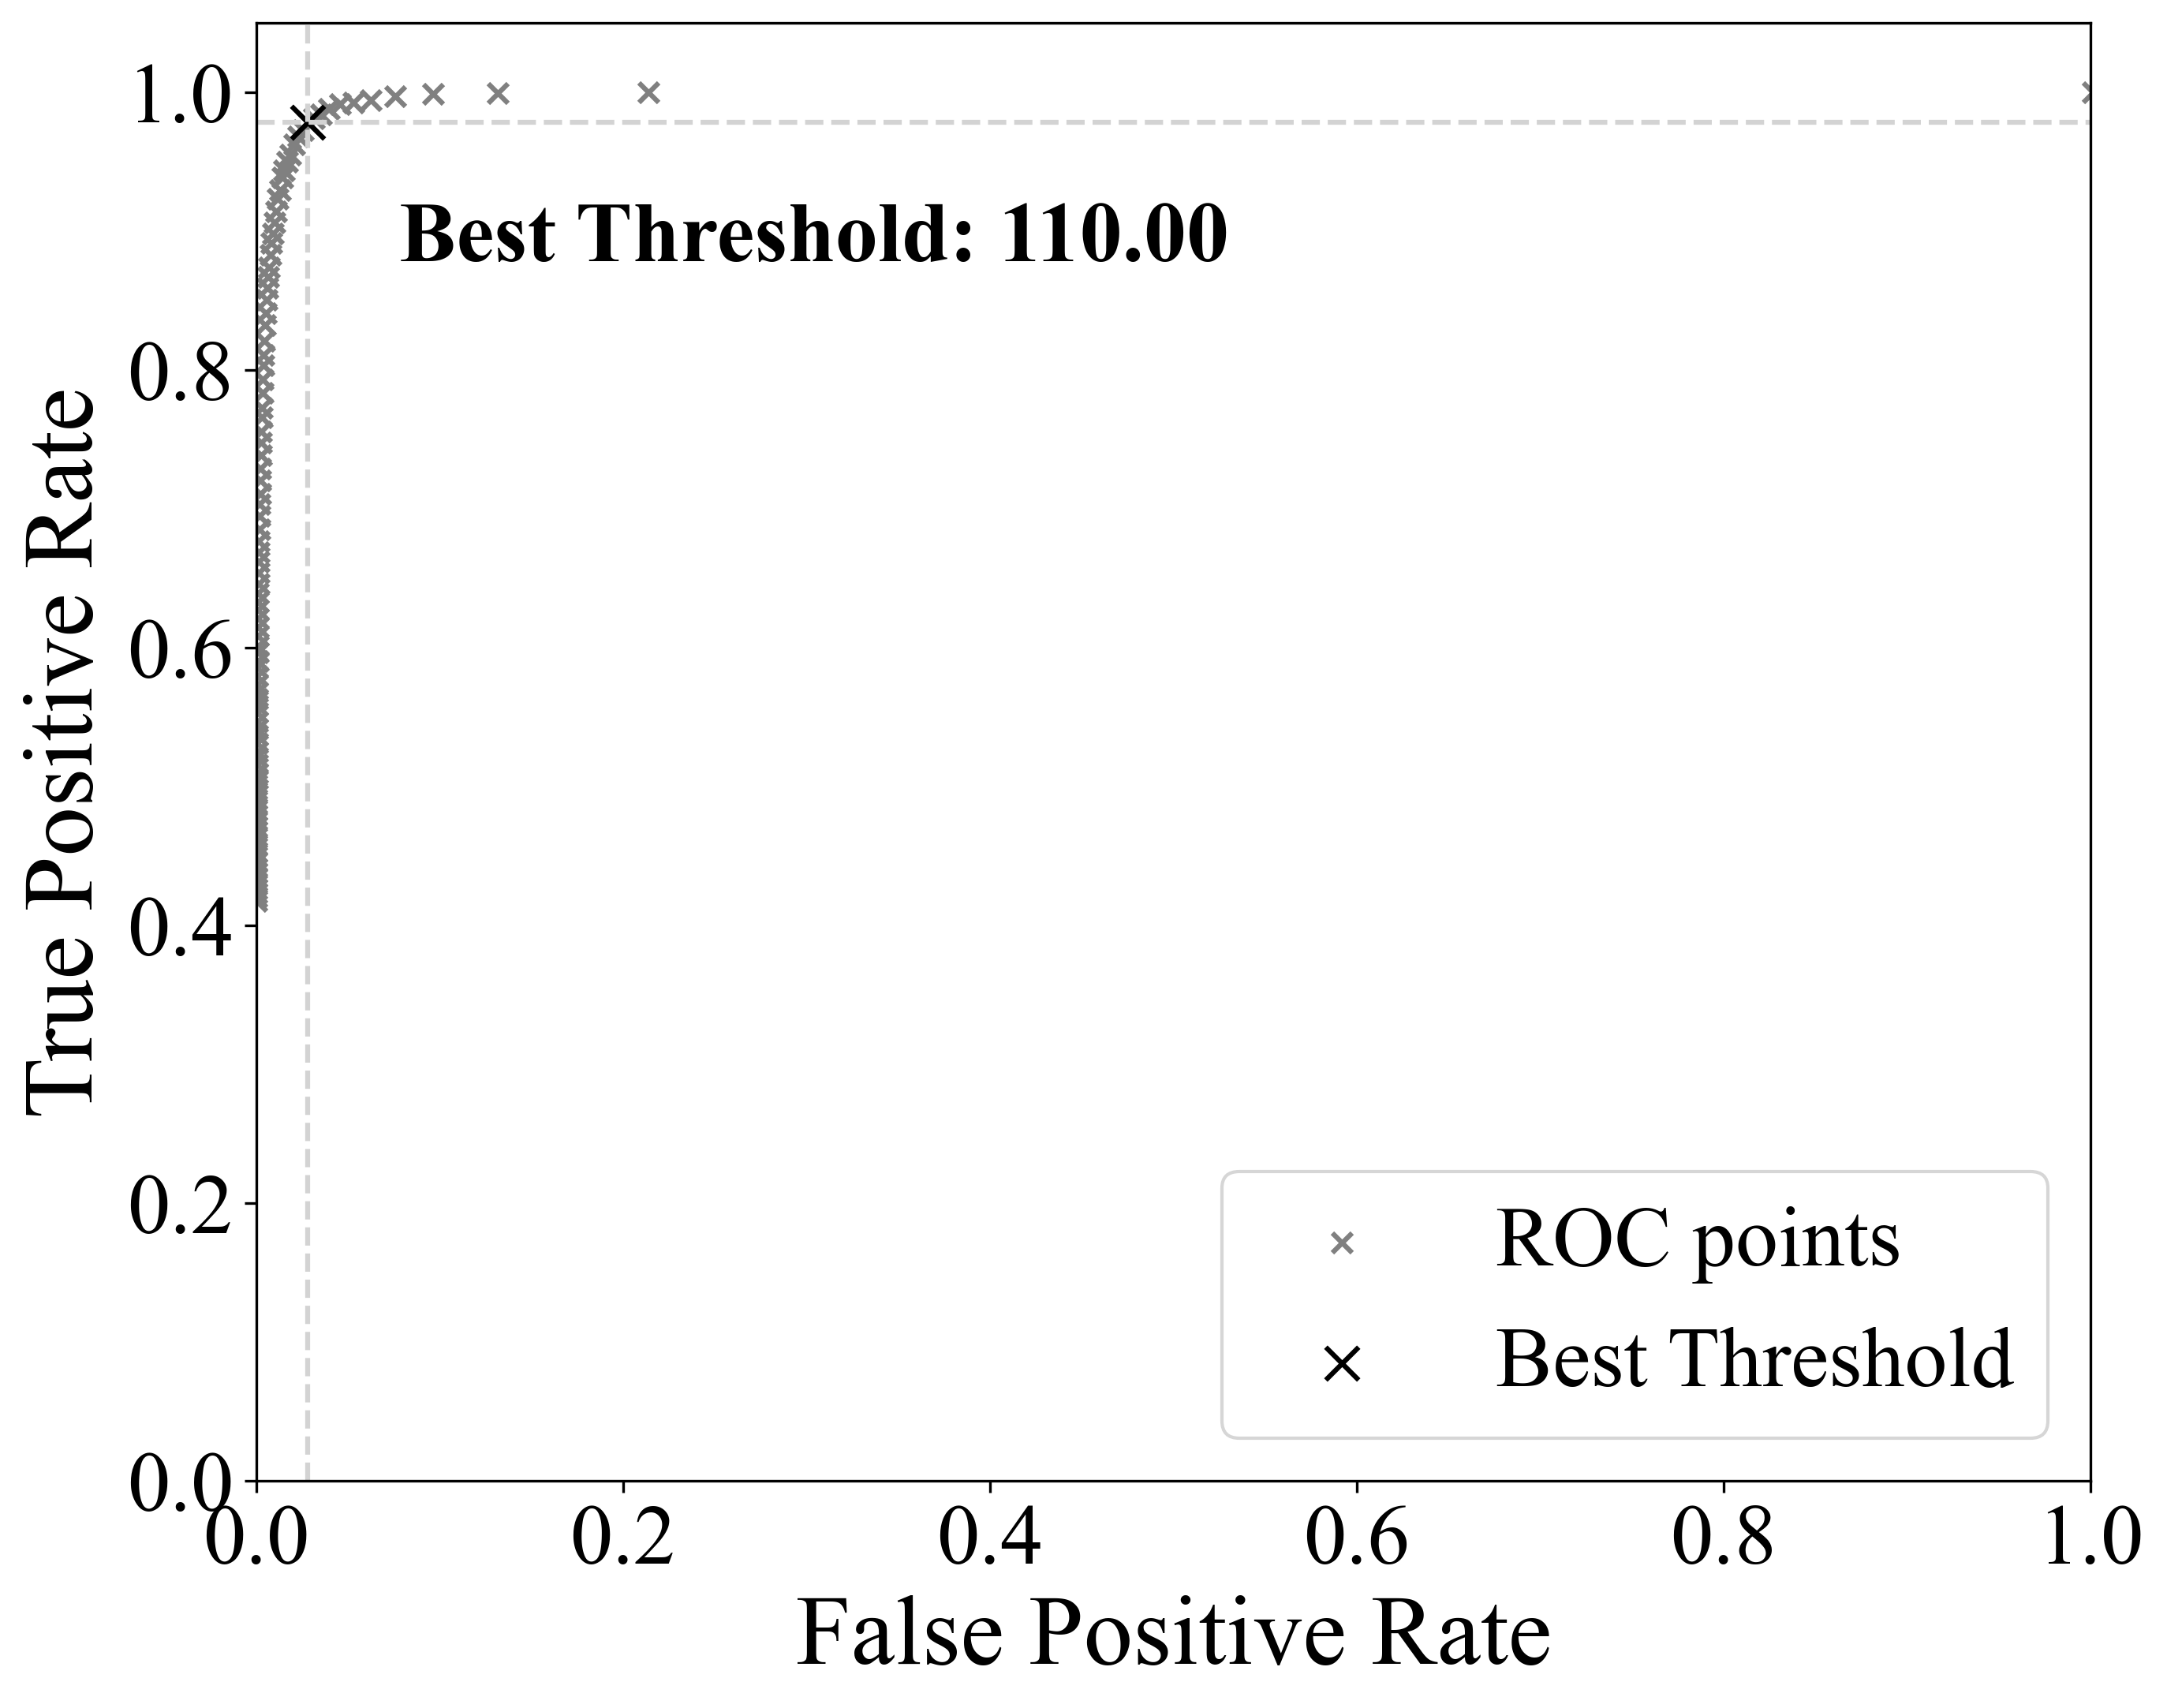

In [10]:
for threshold in thresholds:
    detected_nodes = {node for node, count in cycle_counts.items() if count > threshold}
    
    # 计算TPR和FPR
    TPR, FPR = calculate_tpr_fpr(true_nodes, detected_nodes, total_samples, total_positive_samples)
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)
    
    J = TPR - FPR
    j_statistic.append(J)
best_index = np.argmax(j_statistic)
best_threshold = thresholds[best_index]
best_tpr = tpr_list[best_index]
best_fpr = fpr_list[best_index]
roc_auc = auc(fpr_list, tpr_list)

print(f"The best threshold is {best_threshold:.2f} with TPR: {best_tpr:.2f}, FPR: {best_fpr:.2f}, AUC: {roc_auc:.2f}")
plot_discrete_roc_curve(fpr_list, tpr_list, best_threshold, best_fpr, best_tpr, roc_auc)

In [20]:
threshold = 400

# 在最佳阈值处检测节点
best_detected_nodes = {node for node, count in cycle_counts.items() if count > threshold}

# 保存检测到的节点到txt文件
with open("detected_nodes.txt", "w") as file:
    for node in best_detected_nodes:
        file.write(f"{node}\n")

print(f"Detected nodes have been saved to detected_nodes.txt")


Detected nodes have been saved to detected_nodes.txt
